# Test Delight on DESC-DC2 simulation  in the context of  Vera C. Rubin Obs (LSST) 


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 22 2022



- run at NERSC with **desc-python** python kernel.


Instruction to have a **desc-python** environnement:
- https://confluence.slac.stanford.edu/display/LSSTDESC/Getting+Started+with+Anaconda+Python+at+NERSC


This environnement is a clone from the **desc-python** environnement where package required in requirements can be addded according the instructions here
- https://github.com/LSSTDESC/desc-python/wiki/Add-Packages-to-the-desc-python-environment

We will use the parameter file "tmps/parametersTestRail.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../')
from delight.io import *
from delight.utils import *
from photoz_gp import PhotozGP

# Initialisation

In [2]:
workdir = "tmp"

# Configuration parameters

- now parameters are generated in a dictionnary

In [3]:
list_of_files = os.listdir(workdir)
list_of_files.remove('data') 
list_of_files.remove('delight_data') 
if '.ipynb_checkpoints' in list_of_files:
    list_of_files.remove('.ipynb_checkpoints')
list_of_configfiles = sorted(list_of_files)

In [4]:
list_of_configfiles

['parametersTest-Sens.cfg',
 'parametersTest-VC1e4_ell1e6.cfg',
 'parametersTest.cfg',
 'parametersTest_1.cfg',
 'parametersTest_10.cfg',
 'parametersTest_11.cfg',
 'parametersTest_12.cfg',
 'parametersTest_13.cfg',
 'parametersTest_14.cfg',
 'parametersTest_15.cfg',
 'parametersTest_16.cfg',
 'parametersTest_17.cfg',
 'parametersTest_18.cfg',
 'parametersTest_19.cfg',
 'parametersTest_2.cfg',
 'parametersTest_20.cfg',
 'parametersTest_21.cfg',
 'parametersTest_3.cfg',
 'parametersTest_4.cfg',
 'parametersTest_5.cfg',
 'parametersTest_6.cfg',
 'parametersTest_7.cfg',
 'parametersTest_8.cfg',
 'parametersTest_9.cfg']

# Filters

- First, we must **fit the band filters with a gaussian mixture**. 
This is done with this script:

In [5]:
from delight.interfaces.rail.processFilters import processFilters

In [6]:
#configfilename = list_of_configfiles[9]
#configfilename = 'parametersTest-Sens.cfg'
configfilename = 'parametersTest_21.cfg'
configfullfilename = os.path.join(workdir,configfilename) 
processFilters(configfullfilename)

2022-02-18 14:48:45,116 ipykernel_launcher.py delight.interfaces.rail.processFilters[348] INFO ----- processFilters ------
2022-02-18 14:48:45,118 ipykernel_launcher.py delight.interfaces.rail.processFilters[348] INFO parameter file is tmp/parametersTest_21.cfg


DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y 

# SED

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [7]:
from delight.interfaces.rail.processSEDs import processSEDs

In [8]:
#configfilename = list_of_configfiles[9]
#configfilename = 'parametersTest-Sens.cfg'
configfilename = 'parametersTest_21.cfg'
configfullfilename = os.path.join(workdir,configfilename) 
processSEDs(configfullfilename)

2022-02-18 14:48:58,821 ipykernel_launcher.py, delight.interfaces.rail.processSEDs[348] INFO --- Process SED ---


# Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

## Template Fitting

In [9]:
from delight.interfaces.rail.templateFitting import templateFitting

In [10]:
templateFitting(configfullfilename)

2022-02-18 14:49:09,787 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO --- TEMPLATE FITTING ---
2022-02-18 14:49:09,788 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO ==> New Prior calculation from Benitez
2022-02-18 14:49:09,792 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO Thread number / number of threads: 1 , 1
2022-02-18 14:49:09,793 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO Input parameter file:tmp/parametersTest_21.cfg
2022-02-18 14:49:09,827 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO Number of Target Objects 317
2022-02-18 14:49:09,828 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[348] INFO Thread 0 , analyzes lines 0 , to 317


## Gaussian Process

### Attempt at cross-examination of V_C and ellSigmaPrior influence

In [11]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfullfilename, verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')
    

# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm
zmax = 3.1

2022-02-18 16:35:10,827 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO --- DELIGHT-LEARN ---
2022-02-18 16:35:10,879 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO Number of Training Objects 3755
2022-02-18 16:35:10,880 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO Thread 0 , analyzes lines 0 , to 3755


Creation of GP with V_C = 0.1, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.


2022-02-18 16:35:46,722 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO --- DELIGHT-APPLY ---
2022-02-18 16:35:46,794 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Number of Training Objects 3755
2022-02-18 16:35:46,795 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Number of Target Objects 317
2022-02-18 16:35:46,796 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Thread 0 , analyzes lines 0 to 317


Creation of GP with V_C = 0.1, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.
Study of the influence of ellPriorSigma on likelihood and evidences
Computation of likelihood and evidences for ellPriorSigma = 0.5
0 0.4635763168334961 0.02404165267944336 0.008060932159423828
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
100 0.2894463539123535 0.012530088424682617 0.009267330169677734
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
200 0.31347012519836426 0.009818315505981445 0.009524345397949219
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
300 0.28792381286621094 0.010148048400878906 0.007346391677856445
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)


2022-02-18 16:44:44,284 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO --- DELIGHT-LEARN ---
2022-02-18 16:44:44,327 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO Number of Training Objects 3755
2022-02-18 16:44:44,328 ipykernel_launcher.py, delightLearn_paramSpec[348] INFO Thread 0 , analyzes lines 0 , to 3755


Creation of GP with V_C = 0.1, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.


2022-02-18 16:45:20,531 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO --- DELIGHT-APPLY ---
2022-02-18 16:45:20,610 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Number of Training Objects 3755
2022-02-18 16:45:20,612 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Number of Target Objects 317
2022-02-18 16:45:20,613 ipykernel_launcher.py, delightApply_paramSpecPlot[348] INFO Thread 0 , analyzes lines 0 to 317


Creation of GP with V_C = 0.1, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.
Study of the influence of ellPriorSigma on likelihood and evidences
Computation of likelihood and evidences for ellPriorSigma = 5000000.0
0 0.3444986343383789 0.023471593856811523 0.00774693489074707
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
100 0.2781081199645996 0.011993408203125 0.007135868072509766
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
200 0.2775599956512451 0.009466409683227539 0.008472204208374023
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)
300 0.3071713447570801 0.010676860809326172 0.007941961288452148
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (317, 300)


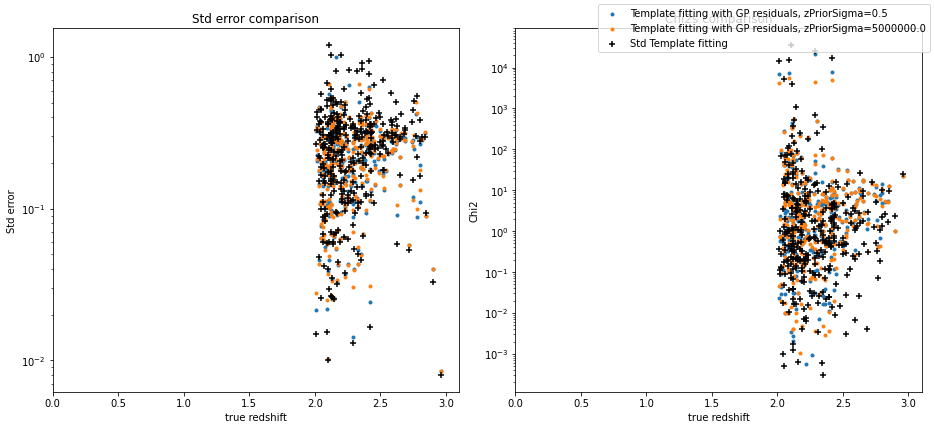

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
metricscww = np.loadtxt(params['metricsFileTemp'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]
chi2scww = ((metricscww[:, i_zt] - metricscww[:, i_ze])/metricscww[:, i_std_ze])**2

from delightLearn_paramSpec import delightLearn_paramSpec
from delightApply_paramSpecPlot import delightApply_paramSpecPlot
for paramVal in [5e-1, 5e6]:
    delightLearn_paramSpec(configfullfilename, plot=False)
    delightApply_paramSpecPlot(configfullfilename, sensitivity=True, ellPriorSigma_list=[paramVal], plot=False)
    # Load the PDF files
    metrics = np.loadtxt(params['metricsFile'])
    pdfs = np.loadtxt(params['redshiftpdfFile'])
    pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
    nobj = pdfatZ.size
    #pdfs /= pdfs.max(axis=1)[:, None]
    #pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
    pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
    chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

    gplot=axs[0].scatter(metrics[:, i_zt], metrics[:, i_std_ze], marker='.', label='Template fitting with GP residuals, zPriorSigma={}'.format(paramVal))
    #axs[0].plot([0, zmax], [0, zmax], 'k')
    axs[1].scatter(metrics[:, i_zt], chi2s, marker='.', color=gplot.get_facecolor()[-1])
    
axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_std_ze],marker='+', label='Std Template fitting', color='k')
axs[1].scatter(metricscww[:, i_zt], chi2scww, marker='+', color='k')
axs[0].set_xlim([0, zmax])
axs[0].set_xlabel('true redshift')
axs[0].set_ylabel('Std error')
axs[0].set_yscale('log')
axs[0].set_title('Std error comparison')
axs[1].set_xlim([0, zmax])
axs[1].set_xlabel('true redshift')
axs[1].set_ylabel('Chi2')
axs[1].set_yscale('log')
axs[1].set_title('Chi2s comparison')
fig.legend()
fig.tight_layout()

# Analyze the outputs

In [13]:
# Load the PDF files
metrics = np.loadtxt(params['metricsFile'])
metricscww = np.loadtxt(params['metricsFileTemp'])
pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

93 7.572692492813116
298 1.261529551341932
245 2.4017152483551953
186 1.829350941218822
175 1.5850966486458413
287 1.5677339624590427
92 4.1335744397691006
75 6.808865773141694
235 1.3630416834802808
24 4.083140780109272
274 2.4317477881671423
316 103.72595196457051
289 8.447422194326814
36 4.614220635923326
199 3.6328180474054106
302 1.7092428501656194
87 1.447043033421517
314 13.68467575953209
100 3.0175585177170845
229 19.561726126233314


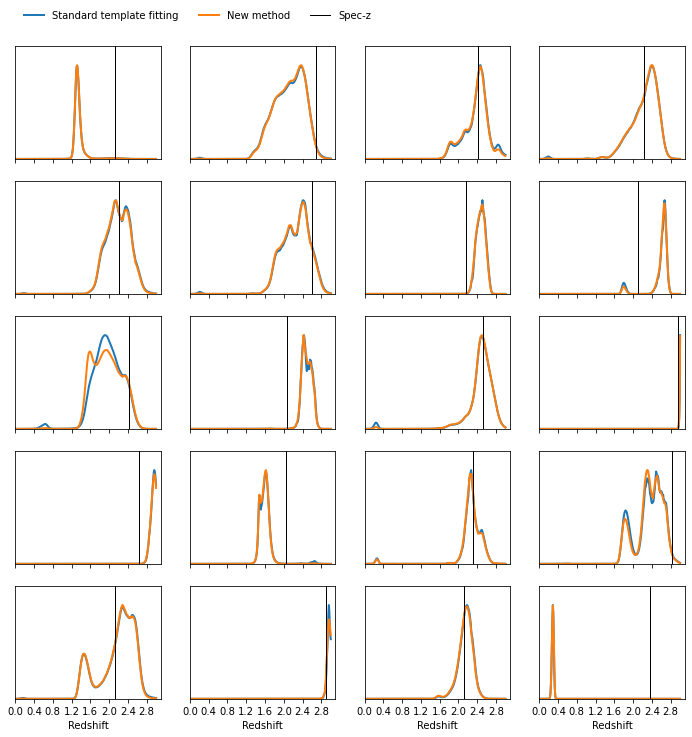

In [14]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label='Spec-z')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    #print(ymax)
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8 ])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


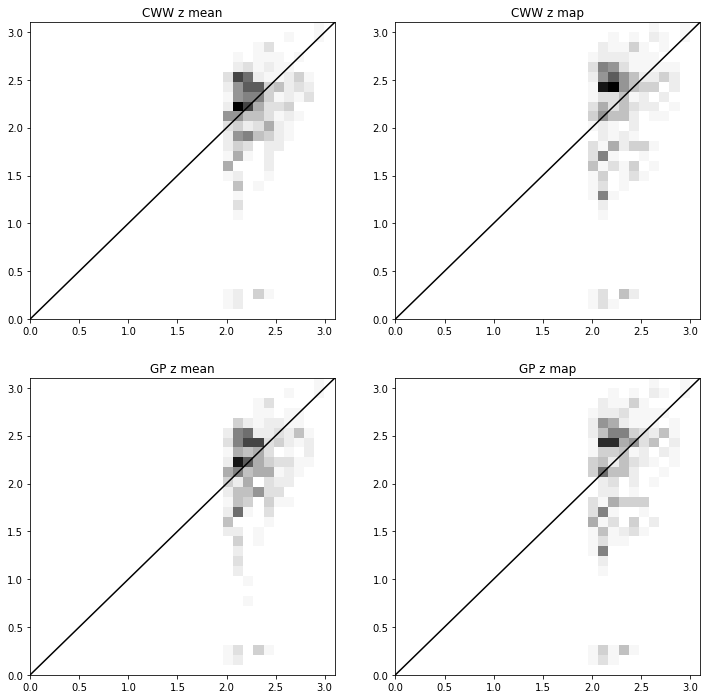

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
zmax = 3.1
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
#fig.tight_layout()

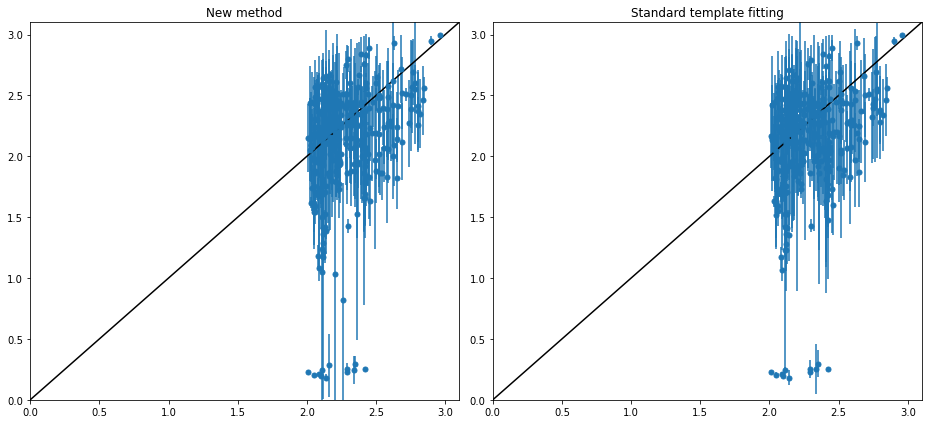

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

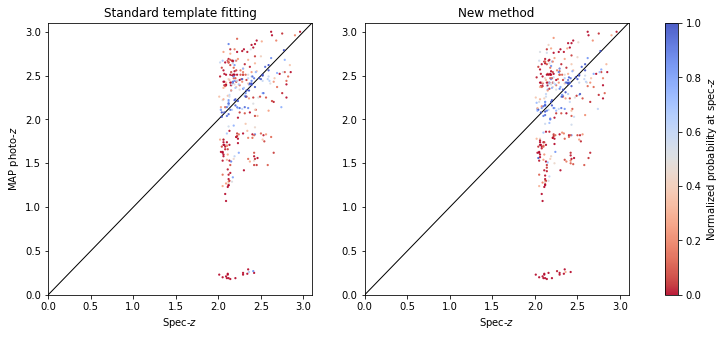

In [17]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.